## Семинар 6 "Segmentation"

Тимонина Дарья Сергеевна

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 26 апреля 2020). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
!unzip test.zip

Archive:  test.zip
   creating: test/
   creating: test/images/
  inflating: test/images/01_test.tif  
  inflating: test/images/02_test.tif  
  inflating: test/images/03_test.tif  
  inflating: test/images/04_test.tif  
  inflating: test/images/05_test.tif  
  inflating: test/images/06_test.tif  
  inflating: test/images/07_test.tif  
  inflating: test/images/08_test.tif  
  inflating: test/images/09_test.tif  
  inflating: test/images/10_test.tif  
  inflating: test/images/11_test.tif  
  inflating: test/images/12_test.tif  
  inflating: test/images/13_test.tif  
  inflating: test/images/14_test.tif  
  inflating: test/images/15_test.tif  
  inflating: test/images/16_test.tif  
  inflating: test/images/17_test.tif  
  inflating: test/images/18_test.tif  
  inflating: test/images/19_test.tif  
  inflating: test/images/20_test.tif  
   creating: test/mask/
 extracting: test/mask/01_test_mask.gif  
 extracting: test/mask/02_test_mask.gif  
 extracting: test/mask/03_test_mask.gif  
 extra

In [2]:
!unzip train.zip

Archive:  train.zip
   creating: training/
   creating: training/1st_manual/
 extracting: training/1st_manual/21_manual1.gif  
 extracting: training/1st_manual/22_manual1.gif  
 extracting: training/1st_manual/23_manual1.gif  
 extracting: training/1st_manual/24_manual1.gif  
 extracting: training/1st_manual/25_manual1.gif  
 extracting: training/1st_manual/26_manual1.gif  
 extracting: training/1st_manual/27_manual1.gif  
 extracting: training/1st_manual/28_manual1.gif  
 extracting: training/1st_manual/29_manual1.gif  
 extracting: training/1st_manual/30_manual1.gif  
 extracting: training/1st_manual/31_manual1.gif  
 extracting: training/1st_manual/32_manual1.gif  
 extracting: training/1st_manual/33_manual1.gif  
 extracting: training/1st_manual/34_manual1.gif  
 extracting: training/1st_manual/35_manual1.gif  
 extracting: training/1st_manual/36_manual1.gif  
 extracting: training/1st_manual/37_manual1.gif  
 extracting: training/1st_manual/38_manual1.gif  
 extracting: training/1

In [3]:
!pip install pytorch_lightning

     |████████████████████████████████| 563kB 7.7MB/s 
     |████████████████████████████████| 276kB 14.1MB/s 
     |████████████████████████████████| 829kB 16.1MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=95788cefe780c2f1cc6d0cdd33c9531c26e5d286428104d2497374ddda61ec8c
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=aa8cdf6f400b4e06b382311d2b78773689a4b082ef7f52971b0c0edbbd26564d
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully unins

In [4]:
!pip install imagecodecs-lite

     |████████████████████████████████| 17.9MB 210kB/s 


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


from PIL import Image
import skimage
from skimage import io

from torch.utils.tensorboard import SummaryWriter

TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [7]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/")

In [8]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)


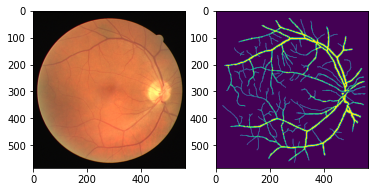

In [9]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [ ]:
import torch

In [25]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        torch.nn.init.xavier_normal_(self.conv[0].weight)
        torch.nn.init.xavier_normal_(self.conv[3].weight)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch),
            nn.Dropout(p=0.1),

        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2) # одновременно тут обратный макс пулинг (stride=2)
        torch.nn.init.xavier_normal_(self.up.weight)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 1024)
        self.up1 = up(1024, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 128)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)
      
      
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        return x

In [26]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [27]:
import torch
model = UNet(3, 1)

# Your model here

In [28]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [29]:
import skimage.transform
import scipy.misc
import imageio


In [36]:
os.makedirs("result")

  adding: result/ (stored 0%)
  adding: result/7.png (deflated 1%)
  adding: result/13.png (deflated 1%)
  adding: result/17.png (deflated 1%)
  adding: result/18.png (deflated 1%)
  adding: result/4.png (deflated 1%)
  adding: result/16.png (deflated 1%)
  adding: result/19.png (deflated 1%)
  adding: result/8.png (deflated 1%)
  adding: result/5.png (deflated 1%)
  adding: result/9.png (deflated 1%)
  adding: result/10.png (deflated 1%)
  adding: result/11.png (deflated 1%)
  adding: result/14.png (deflated 1%)
  adding: result/3.png (deflated 1%)
  adding: result/2.png (deflated 1%)
  adding: result/15.png (deflated 1%)
  adding: result/20.png (deflated 1%)
  adding: result/1.png (deflated 1%)
  adding: result/6.png (deflated 1%)
  adding: result/12.png (deflated 1%)


In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss =  soft_dice_loss
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            

            clear_output(True)
            print('Epoch {0}... (Train/Test) loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], 0,     
                        train_accuracy_epochs[-1], 0)) 
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs



No handles with labels found to put in legend.


Epoch 99... (Train/Test) loss: 0.145/0.000	Accuracy: nan/0.000


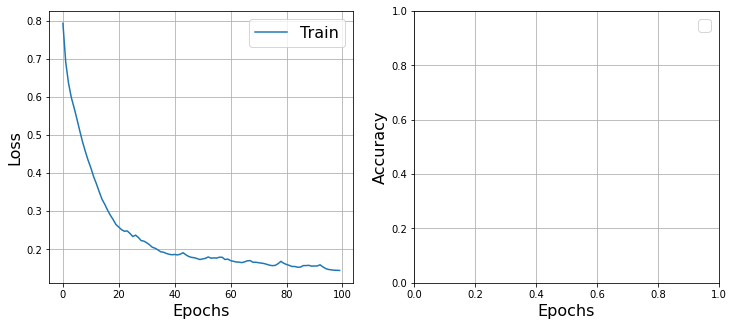

([0.7930396318435669,
  0.6915982604026795,
  0.6364128828048706,
  0.5987189769744873,
  0.5715877652168274,
  0.5425400495529175,
  0.5120110034942627,
  0.48280494213104247,
  0.45751410722732544,
  0.4341609477996826,
  0.41383119821548464,
  0.39057637453079225,
  0.3717940807342529,
  0.3509085655212402,
  0.33136978149414065,
  0.3179885268211365,
  0.30255435705184935,
  0.28924237489700316,
  0.2778895258903503,
  0.26497148275375365,
  0.2583689451217651,
  0.2515126347541809,
  0.24752352237701417,
  0.2484034299850464,
  0.24181051254272462,
  0.2337237000465393,
  0.23728570938110352,
  0.2311549186706543,
  0.22305829524993898,
  0.22153233289718627,
  0.21735315322875975,
  0.21196653842926025,
  0.20551416873931885,
  0.20297669172286986,
  0.19865399599075317,
  0.1936543107032776,
  0.19250175952911378,
  0.18940359354019165,
  0.18714677095413207,
  0.18589333295822144,
  0.18664311170578002,
  0.18546026945114136,
  0.18744100332260133,
  0.1911896586418152,
  0.185

In [31]:
train(model, dataloader, testdataloader, 100, 0.001, device='cuda')

In [34]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)
    #scipy.misc.imsave("test/result/%s.png" % (ex_id + 1), tm)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


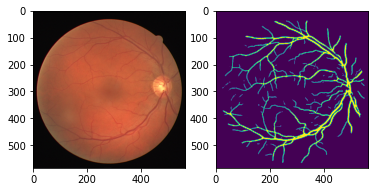

In [35]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

В итоге подошла сеть Unet с некоторыми измениениями в double_conv (добавление слоев) плюс был убран tsf.Resize((128,128)) для картинок (картинки теперь остаются в исходном размере, так сохраняется больше информации). С таким набором получилось побить бейзлайн.